In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from ml import SoftmaxRegression, KNN, CNN
import utils
from image_transformations import clipped_zoom, rotate, noise_filter, gaussian_filter, elastic_transform
%matplotlib inline

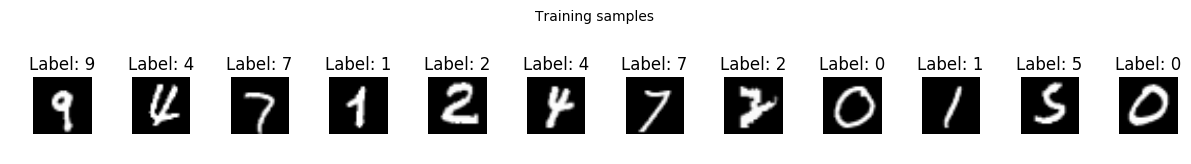

In [2]:
# Exercise 11.1a
data = dict(train=utils.read('digits/digit_train'), test=utils.read('digits/digit_test'))
fig, axes = plt.subplots(1, 12, figsize=(12, 2))
fig.suptitle('Training samples')
for i, ax in enumerate(axes.flat):
    img = data['train']['images'][i].reshape(28, 28)
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title('Label: {:.0f}'.format(data['train']['labels'][i]))
fig.tight_layout()

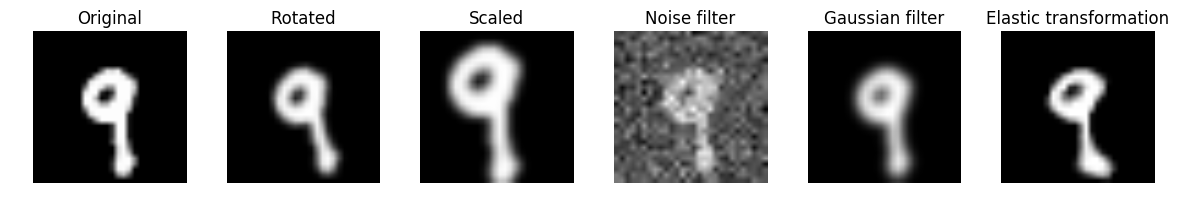

In [4]:
# Add rotated and scaled images
fig, axes = plt.subplots(1, 6, figsize=(12, 4))
img = data['train']['images'][0].reshape(28, 28)
label = data['train']['labels'][0]
utils.plot_img(axes[0], img, 'Original')
utils.plot_img(axes[1], rotate(img, reshape=False), 'Rotated'.format(label))
utils.plot_img(axes[2], clipped_zoom(img, reshape=False), 'Scaled'.format(label))
utils.plot_img(axes[3], noise_filter(img), 'Noise filter'.format(label))
utils.plot_img(axes[4], gaussian_filter(img, reshape=False), 'Gaussian filter'.format(label))
utils.plot_img(axes[5], elastic_transform(img, 9, 2.1, reshape=False), 'Elastic transformation'.format(label))
fig.tight_layout()

In [ ]:
utils.execute_algo(SoftmaxRegression(), 'SR')
utils.execute_algo(KNN(), 'KNN')
cnn_model_dir = os.path.abspath('.').replace('\\', '/') + '/model/'
utils.execute_algo(CNN(checkpoint_dir=cnn_model_dir).restore('mnist_cnn_250'), 'CNN 250', train=False)

Train Convolutional Neural Network
==========

In [5]:
orig_data = dict(train=utils.read('digits/digit_train'), test=utils.read('digits/digit_test'))

In [7]:
import imp
imp.reload(utils)
orig_data2 = orig_data
orig_data2['train']['images'] = orig_data2['train']['images'][:10]
orig_data2['train']['labels'] = orig_data2['train']['labels'][:10]
data = utils.add_morphed_data(orig_data)

c:\python\python35\lib\site-packages\scipy\ndimage\interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


3456 mutations for each image


In [ ]:
# cnn = CNN(checkpoint_dir=model_dir)
# cnn.fit(data['train']['images'], data['train']['labels'], epochs=200, save=True)

In [ ]:
# cnn = CNN(checkpoint_dir=model_dir)
# cnn.restore('mnist_cnn_200')
# utils.execute_algo(cnn, 'CNN 200', train=False)